# Default Parameters

In [1]:
filename = "bank-full.csv"
target_variable_name = "y"

# Load Dataset

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [3]:
from pyspark.sql import functions as F

df = df.withColumn('y', F.when(F.col("y") == 'yes', 1).otherwise(0))

# Data type

In [4]:
def variable_type(df):
    
    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])
    
    return char_vars, num_vars

char_vars, num_vars = variable_type(df)
num_vars.remove(target_variable_name)

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

def category_to_index(df, char_vars):
    
    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

df, char_labels = category_to_index(df, char_vars)
df = df.select([c for c in df.columns if c not in char_vars])

def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

df = rename_columns(df, char_vars)

# Assemble vectors

In [5]:
from pyspark.ml.feature import VectorAssembler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df, assembleModel, selectedCols

#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove(target_variable_name)

# apply the function on our dataframe
df, assembleModel, selectedCols = assemble_vectors(df, features_list, target_variable_name)

# Train, Test

In [6]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)

In [7]:
train.count(), test.count()

(31457, 13754)

# Random Forest model

In [8]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(featuresCol='features', labelCol='y')
clf_model = clf.fit(train)
print(clf_model.featureImportances)
print(clf_model.toDebugString)

(16,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],[0.031090152784108538,0.006759686356856635,0.006865907076428202,0.3859753325303087,0.0072849498073675745,0.08449516335304408,0.0333368249282729,0.00691516461132712,0.0033139571305667672,0.002775589104765669,0.00026869796119765026,0.022388583227178672,0.0020933269129018465,0.01349241473441872,0.13765179028447877,0.25529245919677834])
RandomForestClassificationModel (uid=RandomForestClassifier_921383b9ec6f) with 20 trees
  Tree 0 (weight 1.0):
    If (feature 6 <= 0.5)
     If (feature 1 <= 228.5)
      If (feature 14 <= 7.5)
       Predict: 0.0
      Else (feature 14 > 7.5)
       If (feature 3 <= 93.5)
        Predict: 0.0
       Else (feature 3 > 93.5)
        If (feature 2 <= 17.5)
         Predict: 0.0
        Else (feature 2 > 17.5)
         Predict: 1.0
     Else (feature 1 > 228.5)
      If (feature 11 <= 0.5)
       If (feature 14 <= 7.5)
        Predict: 0.0
       Else (feature 14 > 7.5)
        If (feature 14 <= 9.5)
         Predic

In [9]:
train_pred_result = clf_model.transform(train)
test_pred_result = clf_model.transform(test)

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType, DoubleType

def evaluation_metrics(df, target_variable_name):
    pred = df.select("prediction", target_variable_name)
    pred = pred.withColumn(target_variable_name, pred[target_variable_name].cast(DoubleType()))
    pred = pred.withColumn("prediction", pred["prediction"].cast(DoubleType()))
    metrics = MulticlassMetrics(pred.rdd.map(tuple))
    # confusion matrix
    cm = metrics.confusionMatrix().toArray()
    acc = metrics.accuracy #accuracy
    misclassification_rate = 1 - acc #misclassification rate
    precision = metrics.precision(1.0) #precision
    recall = metrics.recall(1.0) #recall
    f1 = metrics.fMeasure(1.0) #f1-score
    #roc value
    evaluator_roc = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction', metricName='areaUnderROC')
    roc = evaluator_roc.evaluate(df)
    evaluator_pr = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction', metricName='areaUnderPR')
    pr = evaluator_pr.evaluate(df)
    return cm, acc, misclassification_rate, precision, recall, f1, roc, pr

In [11]:
train_cm, train_acc, train_miss_rate, train_precision, \
        train_recall, train_f1, train_roc, train_pr = evaluation_metrics(train_pred_result, target_variable_name)

In [12]:
test_cm, test_acc, test_miss_rate, test_precision, \
        test_recall, test_f1, test_roc, test_pr = evaluation_metrics(test_pred_result, target_variable_name)

# Comparision of metrics

In [13]:
print('Train accuracy - ', train_acc, ', Test accuracy - ', test_acc)
print('Train misclassification rate - ', train_miss_rate, ', Test misclassification rate - ', test_miss_rate)
print('Train precision - ', train_precision, ', Test precision - ', test_precision)
print('Train recall - ', train_recall, ', Test recall - ', test_recall)
print('Train f1 score - ', train_f1, ', Test f1 score - ', test_f1)
print('Train ROC - ', train_roc, ', Test ROC - ', test_roc)
print('Train PR - ', train_pr, ', Test PR - ', test_pr)

Train accuracy -  0.893823314365642 , Test accuracy -  0.8973389559400902
Train misclassification rate -  0.106176685634358 , Test misclassification rate -  0.10266104405990983
Train precision -  0.8077571669477235 , Test precision -  0.8495934959349594
Train recall -  0.1292847503373819 , Test recall -  0.13194444444444445
Train f1 score -  0.222894369474174 , Test f1 score -  0.2284153005464481
Train ROC -  0.895456796052486 , Test ROC -  0.8921047990172886
Train PR -  0.5681637064646863 , Test PR -  0.5681101063213608


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):
    
    list_values = ['0', '1']
    
    plt.figure(1, figsize=(10,5))
    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Train data predictions')
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values, 
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Test data predictions')

    plt.tight_layout()
    return None

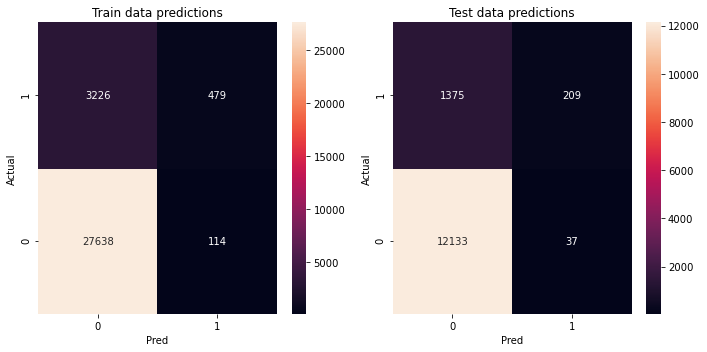

In [15]:
make_confusion_matrix_chart(train_cm, test_cm)

In [16]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        results_collect = rdd.collect()
        for row in results_collect:
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [17]:
import matplotlib.pyplot as plt

def plot_roc_pr(df, target_variable_name, plot_type, legend_value, title):
    
    preds = df.select(target_variable_name,'probability')
    preds = preds.rdd.map(lambda row: (float(row['probability'][1]), float(row[target_variable_name])))
    # Returns as a list (false positive rate, true positive rate)
    points = CurveMetrics(preds).get_curve(plot_type)
    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title(title)
    
    if plot_type == 'roc':
        plt.xlabel('False Positive Rate (1-Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.plot(x_val, y_val, label = 'AUC = %0.2f' % legend_value)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    
    if plot_type == 'pr':
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot(x_val, y_val, label = 'Average Precision = %0.2f' % legend_value)
        plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--')
    
    plt.legend(loc = 'lower right')
    return None

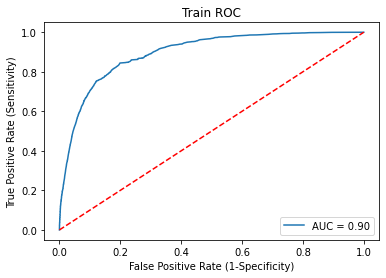

In [18]:
plot_roc_pr(train_pred_result, target_variable_name, 'roc', train_roc, 'Train ROC')

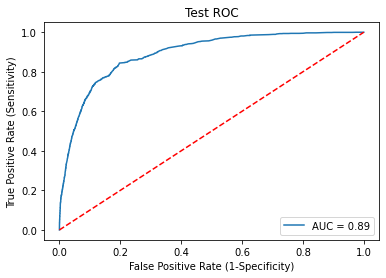

In [19]:
plot_roc_pr(test_pred_result, target_variable_name, 'roc', test_roc, 'Test ROC')

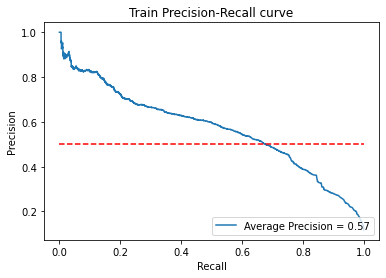

In [20]:
plot_roc_pr(train_pred_result, target_variable_name, 'pr', train_pr, 'Train Precision-Recall curve')

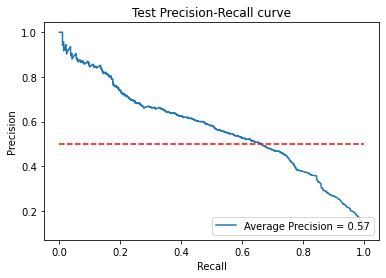

In [21]:
plot_roc_pr(test_pred_result, target_variable_name, 'pr', test_pr, 'Test Precision-Recall curve')

# Save model objects for future scoring

In [22]:
import os
import pickle

path_to_write_output = '/home/work/Desktop/score_code_objects'
#create directoyr, skip if already exists
try:
    os.mkdir(path_to_write_output)
except:
    pass

#save pyspark objects
char_labels.write().overwrite().save(path_to_write_output + '/char_label_model.h5')
assembleModel.write().overwrite().save(path_to_write_output + '/assembleModel.h5')
clf_model.write().overwrite().save(path_to_write_output + '/clf_model.h5')

#save python object
list_of_vars = [features_list, char_vars, num_vars]
with open(path_to_write_output + '/file.pkl', 'wb') as handle:
    pickle.dump(list_of_vars, handle) 

# Score code

In [1]:
# ### helper functions - this will be put in a separate file
# #helper functions
# from pyspark.sql import functions as F
# import pickle
# from pyspark.ml import PipelineModel
# from pyspark.ml.classification import RandomForestClassificationModel
# from pyspark.sql.functions import udf
# from pyspark.sql.types import IntegerType, DoubleType

# # read model objects saved from the training process
# path_to_read_objects = '/home/work/Desktop/score_code_objects'

# #pyspark objects
# char_labels = PipelineModel.load(path_to_read_objects + '/char_label_model.h5')
# assembleModel = PipelineModel.load(path_to_read_objects + '/assembleModel.h5')
# clf_model = RandomForestClassificationModel.load(path_to_read_objects + '/clf_model.h5')
# #python objects
# with open(path_to_read_objects + '/file.pkl', 'rb') as handle:
#     features_list, char_vars, num_vars = pickle.load(handle)
    
# #make necessary transformations
# def rename_columns(df, char_vars):
#     mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
#     df = df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])
#     return df

# # score the new data
# def score_new_df(scoredf):
#     X = scoredf.select(features_list)
#     X = char_labels.transform(X)
#     X = X.select([c for c in X.columns if c not in char_vars])
#     X = rename_columns(X, char_vars)
#     final_X = assembleModel.transform(X)
#     final_X.cache()
#     pred = clf_model.transform(final_X)
#     pred.cache()
#     split_udf = udf(lambda value: value[1].item(), DoubleType())
#     pred = pred.select('prediction', split_udf('probability').alias('probability'))
#     return pred

In [1]:
# import necessary packages
from pyspark.sql import SparkSession
from helper import *

# new data to score
filename = "score_data.csv" 
spark = SparkSession.builder.getOrCreate()
score_data = spark.read.csv(filename, header=True, inferSchema=True, sep=';')

#score the data
path_to_output_scores = '.'
final_scores_df = score_new_df(score_data)
#final_scores_df.show()
final_scores_df.repartition(1).write.format('csv').mode("overwrite").options(sep='|', header='true').save(path_to_output_scores + "/predictions.csv")